# Fraud Transaction Detection

## 0. Connection to Google Drive

Connecting to Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Analysis

Importing Necessay Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

                                       **Key Findings from Exploratory Analysis**

---

1.   **Severe Class Imbalance**


*   Fraud rate is extremely low: 8,213 fraudulent cases out of 6,362,620 transactions (≈0.129%).
*   Accuracy is misleading in this context; instead, evaluation should rely on PR-AUC, recall at low false positive rates, precision@k, and cost-based metrics.




---


2. **Temporal Nature of Data**


*   The step column ranges from 1 to 743, where each step corresponds to one hour (~31 days total).
*   Since transactions are time-dependent, time-based splits (training on earlier steps, validating on later ones) should be used to avoid data leakage.

---

3. **Strong Signal from Transaction Types**

* The type variable has five categories: ['PAYMENT','TRANSFER','CASH_OUT','DEBIT','CASH_IN'].

* Fraud is concentrated in TRANSFER and CASH_OUT, while the other types are typically non-fraudulent.

---

4. **Balance Arithmetic Patterns**

* *newbalanceOrig ≈ oldbalanceOrg - amount (correlation ≈ 0.9988).*

* newbalanceDest and oldbalanceDest are also highly correlated (≈0.9765), though often one/both are zero (common with merchants).

* This creates multicollinearity, but also allows construction of powerful derived features:

* *errorBalanceOrig = oldbalanceOrg - amount - newbalanceOrig*

* *errorBalanceDest = oldbalanceDest + amount - newbalanceDest*

* These “error” features capture inconsistencies in balances — which fraud often introduces — making them highly predictive.

---

5. ID Columns as Feature Sources (Not Direct Features)

* nameOrig (always starting with C…) and nameDest (C… for customers, M… for merchants) are identifiers.

* While IDs themselves should not be used as features, they are feature goldmines (e.g., distinguishing whether destination is a merchant).

---

6. isFlaggedFraud is Not Useful

* Only 16 transactions are flagged by isFlaggedFraud.

* This is likely an upstream rule-based flag (e.g., very large transactions).

* It adds little value for predictive modeling and should be dropped to avoid circularity.
---

Loading Dataset Saved in the Drive

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 6362620
Number of columns: 11


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
stepCol = len(df['step'].unique())
print('No. Unique values in "step" column:', stepCol)
typecol = df['type'].unique()
print('Unique values in "type" column:', typecol)
isFraudCol = df['isFraud'].unique()
print('Unique values in "isFraud" column:', isFraudCol)
isFlaggedFraudCol = df['isFlaggedFraud'].unique()
print('Unique values in "isFlaggedFraud" column:', isFlaggedFraudCol)
(df['isFlaggedFraud']==1).sum()
print('No. of Fraud Flagged.')

No. Unique values in "step" column: 743
Unique values in "type" column: ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Unique values in "isFraud" column: [0 1]
Unique values in "isFlaggedFraud" column: [0 1]
No. of Fraud Flagged.


In [53]:
corr1 = np.corrcoef(df['oldbalanceOrg'],df['newbalanceOrig'])
print('Correlation between oldbalanceOrg and newbalanceOrig :-')
print(np.corrcoef(df['oldbalanceOrg'],df['newbalanceOrig']))

Correlation between oldbalanceOrg and newbalanceOrig :-
[[1.         0.99880276]
 [0.99880276 1.        ]]


In [54]:
corr2 = np.corrcoef(df['amount'],df['newbalanceOrig'])
print('correlation between amount and newbalanceOrig :- ')
print(corr2)

correlation between amount and newbalanceOrig :- 
[[ 1.         -0.00786093]
 [-0.00786093  1.        ]]


In [56]:
corr3 = np.corrcoef(df['newbalanceDest'],df['oldbalanceDest'])
print('correlation between newbalanceDest and oldbalanceDest :- ')
print(corr3)

correlation between newbalanceDest and oldbalanceDest :- 
[[1.         0.97656851]
 [0.97656851 1.        ]]


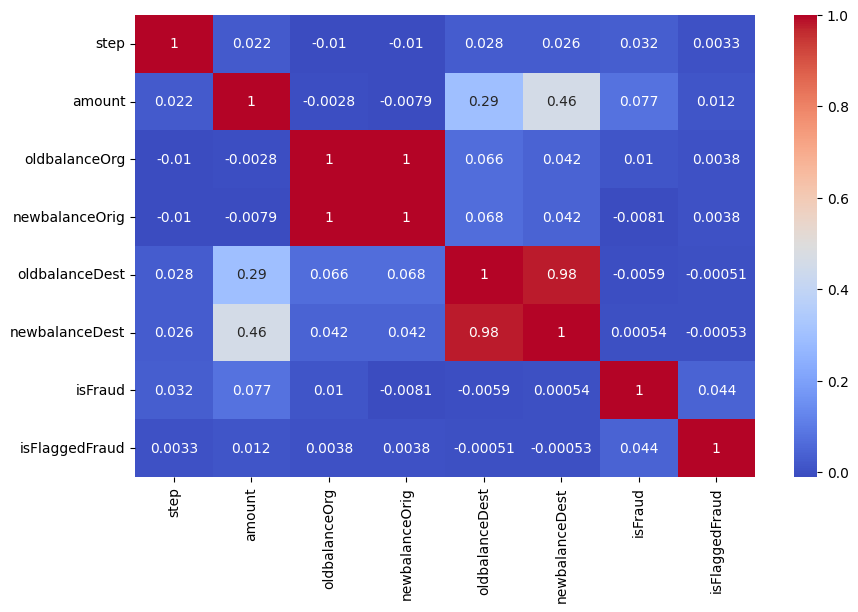

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(columns=['type','nameOrig','nameDest']).corr(), annot=True, cmap="coolwarm")
plt.show()

In [12]:
print(pd.crosstab(df['type'], df['isFraud'], normalize='index').sort_values(1, ascending=False))

isFraud          0         1
type                        
TRANSFER  0.992312  0.007688
CASH_OUT  0.998160  0.001840
CASH_IN   1.000000  0.000000
DEBIT     1.000000  0.000000
PAYMENT   1.000000  0.000000


In [13]:
# also raw counts
pd.crosstab(df['type'], df['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


<Axes: title={'center': 'Fraud rate by step (hour)'}, xlabel='step'>

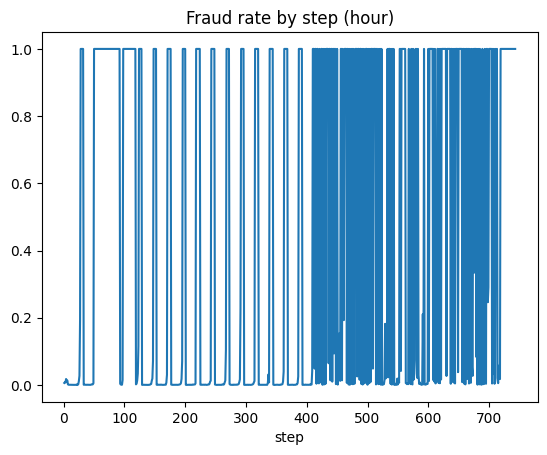

In [14]:
# Fraud rate over time
fraud_by_step = df.groupby('step')['isFraud'].mean()
fraud_by_step.plot(title='Fraud rate by step (hour)')

<Axes: title={'center': 'Smoothed Fraud Rate'}, xlabel='step'>

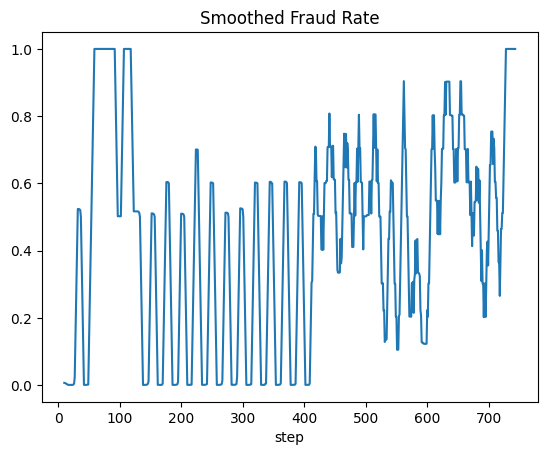

In [15]:
fraud_by_step.rolling(window=10).mean().plot(title='Smoothed Fraud Rate')

<Axes: title={'center': 'Transaction Volume by Step'}, xlabel='step'>

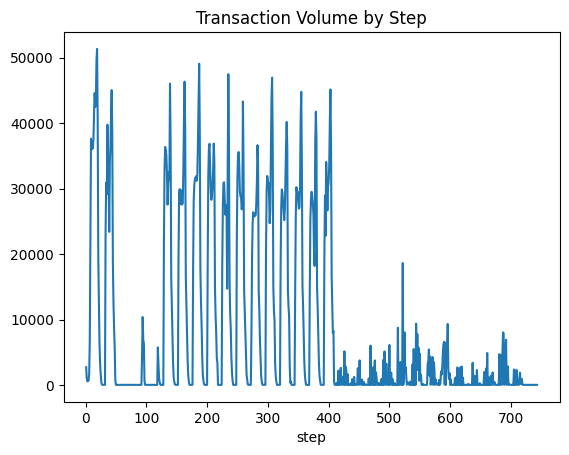

In [16]:
df.groupby('step').size().plot(title='Transaction Volume by Step')

## 2. Feature Engineering

**Features are the bridge between raw data and insights. I’ve split this into two phases: *pre-transaction* and *post-transaction* dataset preparation.**

### Pre-Transaction Dataset Preparation

In [17]:
pre_transaction_df = df

In [18]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


                             **Reasons of Adding New Features in Pre-Transaction Dataset**


1. *dest_is_merchant* – This feature checks whether the destination account is a merchant (indicated by names starting with "M"). Fraudsters often target merchant accounts for quick withdrawals, so this feature helps capture suspicious transaction patterns.


2. *isCashOutOrTransfer* – Transactions that are either CASH_OUT or TRANSFER are more likely to be associated with fraud compared to other types. This binary feature helps the model focus on high-risk transaction types.


3. *step_mod_day* – By taking the transaction step modulo 24, we approximate the time of day of the transaction. Fraudulent activities may cluster during unusual hours (e.g., late night or early morning).


4. *step_week* – By dividing the transaction step into weeks, we track the week number. Fraud behavior might show temporal trends (e.g., spikes at the beginning or end of the week).




In [19]:
pre_transaction_df['dest_is_merchant'] = df['nameDest'].str.startswith('M').astype('int8')
pre_transaction_df['isCashOutOrTransfer'] = ((df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')).astype('int8')
pre_transaction_df['step_mod_day'] = df['step'] % 24
pre_transaction_df['step_week'] = df['step'] // 24 // 7


* Dropped nameOrig, newbalanceOrig, nameDest, newbalanceDest, and isFlaggedFraud since they either directly reveal identity (IDs), are redundant, or leak information not available before the transaction.*

* Added log_amount to reduce skewness in transaction amounts and stabilize model learning.

* Created amt_over_oldOrig to capture the ratio of transaction amount relative to sender’s old balance, indicating unusual spending patterns.

* Created amt_over_oldDest to capture the ratio of transaction amount relative to receiver’s old balance, highlighting abnormal incoming transfers.

* Dropped raw amount after log transformation and ratio features to avoid redundancy.

* Dropped type since it has already been encoded into the isCashOutOrTransfer feature.

In [20]:
pre_transaction_df = pre_transaction_df.drop(columns=['nameOrig','newbalanceOrig','nameDest','newbalanceDest','isFlaggedFraud'])
pre_transaction_df['log_amount'] = np.log1p(pre_transaction_df['amount'])

pre_transaction_df['amt_over_oldOrig'] = df['amount']/(df['oldbalanceOrg'] + 1e-6)
pre_transaction_df['amt_over_oldDest'] = df['amount']/(df['oldbalanceDest'] + 1e-6)

pre_transaction_df = pre_transaction_df.drop(columns=['amount'])
pre_transaction_df =  pre_transaction_df.drop(columns=['type'])
pre_transaction_df

,step,oldbalanceOrg,oldbalanceDest,isFraud,dest_is_merchant,isCashOutOrTransfer,step_mod_day,step_week,log_amount,amt_over_oldOrig,amt_over_oldDest
0,1,170136.00,0.00,0,1,0,1,0,9.194276,0.057834,9.839640e+09
1,1,21249.00,0.00,0,1,0,1,0,7.531166,0.087735,1.864280e+09
2,1,181.00,0.00,1,0,1,1,0,5.204007,1.000000,1.810000e+08
3,1,181.00,21182.00,1,0,1,1,0,5.204007,1.000000,8.544991e-03
4,1,41554.00,0.00,0,1,0,1,0,9.364703,0.280795,1.166814e+10
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,0.00,1,0,1,23,4,12.735768,1.000000,3.396821e+11
6362616,743,6311409.28,0.00,1,0,1,23,4,15.657870,1.000000,6.311409e+12
6362617,743,6311409.28,68488.84,1,0,1,23,4,15.657870,1.000000,9.215238e+01
6362618,743,850002.52,0.00,1,0,1,23,4,13.652996,1.000000,8.500025e+11


In [21]:
pre_transaction_df.head()

,step,oldbalanceOrg,oldbalanceDest,isFraud,dest_is_merchant,isCashOutOrTransfer,step_mod_day,step_week,log_amount,amt_over_oldOrig,amt_over_oldDest
0,1,170136.0,0.0,0,1,0,1,0,9.194276,0.057834,9.839640e+09
1,1,21249.0,0.0,0,1,0,1,0,7.531166,0.087735,1.864280e+09
2,1,181.0,0.0,1,0,1,1,0,5.204007,1.000000,1.810000e+08
3,1,181.0,21182.0,1,0,1,1,0,5.204007,1.000000,8.544991e-03
4,1,41554.0,0.0,0,1,0,1,0,9.364703,0.280795,1.166814e+10


### Post-Transaction Dataset Preparation

In [22]:
post_trasaction_df = df

                                 **Histogram Interpretation**

* When plotted the histogram of err_orig for fraud (isFraud == 1) and non-fraud (isFraud == 0) transactions, observation and conclusion :-

* **Observations**

 * *Non-Fraud (isFraud == 0)*
   * A sharp spike at -100000 with a height of about 2.7.
   * Another noticeable spike at 0 with a height of around 1.25.
   * A small spread near zero, indicating slight variability.

 * *Fraud (isFraud == 1)*
   * A single massive spike at 0, with a height close to 8000.
   * No visible spread at all.

* **Interpretation**

 * Spike at err_orig = 0 (Both Fraud & Non-Fraud)

 * This shows that for many transactions:

 * 𝑜𝑙𝑑𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝑂𝑟𝑔−𝑎𝑚𝑜𝑢𝑛𝑡=𝑛𝑒𝑤𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝑂𝑟𝑖𝑔

 * In fraud cases, this almost always holds true — suggesting that either fraudsters (or the way fraudulent data is generated) are ensuring perfect balance updates to avoid suspicion.

 * Spike at err_orig = -100000 (Only Non-Fraud)

 * This looks unusual. Such a large negative error means something like:    *    *𝑛𝑒𝑤𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝑂𝑟𝑖𝑔 = 𝑜𝑙𝑑𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝑂𝑟𝑔 − 𝑎𝑚𝑜𝑢𝑛 + 100000*

 * This could happen if:
    * newbalanceOrig is missing or defaulted to 0.
    * oldbalanceOrg = 0 and amount = 100000.

 * It suggests that in non-fraud transactions, there are many cases where the origin account had no money but still a large amount was deducted — possibly due to system glitches, data artifacts, or unusual non-fraud behaviors.

 * Tight Spread Near Zero (Non-Fraud Only)

   * Most non-fraud cases show small errors, which is expected in real banking systems (due to rounding differences, timing lags, or small inconsistencies).

   * This natural variability is what we’d typically see in legitimate transactions.

   * No Spread in Fraud Cases

   * Fraud transactions are “too perfect” — every error is exactly zero.

 * This strongly suggests either:

   * Fraudulent transactions were synthetically generated to look clean.

   * Or fraudsters are deliberately making balances consistent to avoid detection.

---

  * **In short: Non-fraud transactions show natural noise, occasional glitches, and anomalies (-100000 spike), while fraud transactions are unnaturally perfect (zero error).**

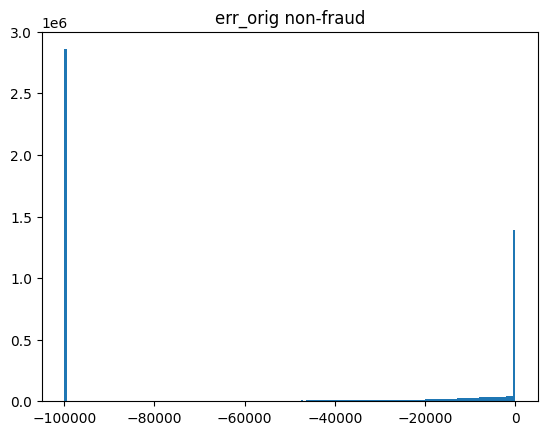

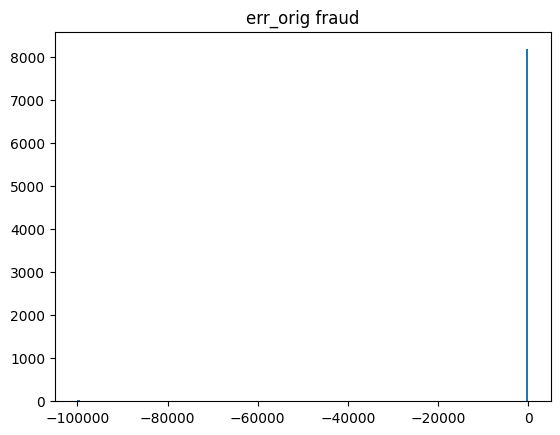

In [23]:
post_trasaction_df['errBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
post_trasaction_df['errBalaceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# How separated are they?
df.groupby('isFraud')[['errBalanceOrig','errBalaceDest']].describe()

# Visual feel
import matplotlib.pyplot as plt
plt.hist(post_trasaction_df.loc[df.isFraud==0,'errBalanceOrig'].clip(-1e5,1e5), bins=200); plt.title('err_orig non-fraud'); plt.show()
plt.hist(post_trasaction_df.loc[df.isFraud==1,'errBalanceOrig'].clip(-1e5,1e5), bins=200); plt.title('err_orig fraud'); plt.show()

                               **Observations on err_dest**
* For Non-Fraud Transactions (isFraud == 0):
   * A spike at -100000 with a small height (~0.01).
   * A large spike at 0 (height ~2.2).
   * The distribution also spreads towards the right.
   * Another spike at 100000 (height ~1.2).


* For Fraud Transactions (isFraud == 1):
   * observed a big spike at -100000 (height ~50).
   * A very strong spike at 0 (height ~3400).
   * The distribution again spreads to the right.
   * Another huge spike at 100000 (height ~3300).

* **Interpretation of err_dest**

 * Spike at 0
    * This shows cases where the balance update is perfect: 𝑜𝑙𝑑𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝐷𝑒𝑠𝑡+𝑎𝑚𝑜𝑢𝑛𝑡=𝑛𝑒𝑤𝑏𝑎𝑙𝑎𝑛𝑐𝑒D𝑒𝑠𝑡

 * Found this pattern in both fraud and non-fraud transactions, but it’s dominant in fraud, which suggests fraud attempts are deliberately crafted to appear legitimate.

 * Spike at 100000
    * This means: 𝑛𝑒𝑤𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝐷𝑒𝑠𝑡=𝑜𝑙𝑑𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝐷𝑒𝑠𝑡+𝑎𝑚𝑜𝑢𝑛𝑡−100000

 * Probabily this implies either the newbalanceDest is missing/zero or there’s some default subtraction of 100000 (maybe a placeholder or error code).

* In fraud transactions, this spike is very strong, which makes me think many destination accounts never actually get updated — a classic fraud signature.

* Spike at -100000
  * This corresponds to: 𝑛𝑒𝑤𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝐷𝑒𝑠𝑡=𝑜𝑙𝑑𝑏𝑎𝑙𝑎𝑛𝑐𝑒𝐷𝑠𝑡+𝑎𝑚𝑜𝑢𝑛𝑡+100000

* That’s unusual because it suggests the destination balance increased more than expected — possibly due to double counting or a system glitch.
*  Also noticable thaat in fraud cases (though smaller than the other spikes), which could mean data corruption or intentional manipulation.

  * Spread to the Right

  * In non-fraud, I interpret this as natural variability — different amounts, rounding issues, timing delays.

  * In fraud, the spread is much tighter, which to me suggests scripted or controlled behavior.

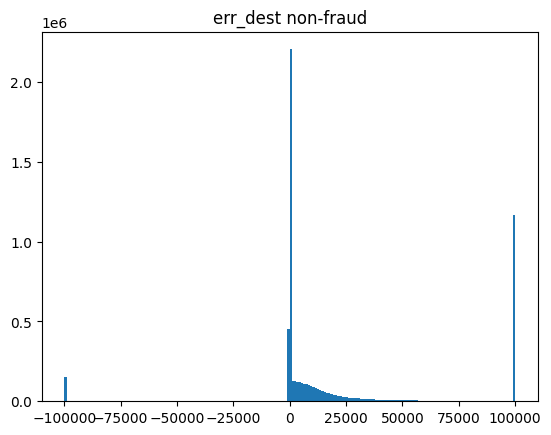

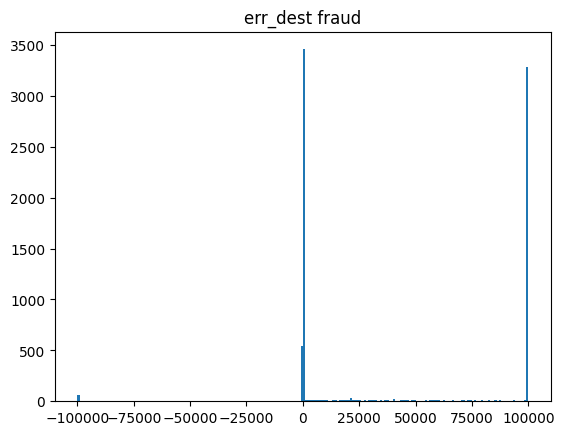

In [24]:
plt.hist(post_trasaction_df.loc[df.isFraud==0,'errBalaceDest'].clip(-1e5,1e5), bins=200); plt.title('err_dest non-fraud'); plt.show()
plt.hist(post_trasaction_df.loc[df.isFraud==1,'errBalaceDest'].clip(-1e5,1e5), bins=200); plt.title('err_dest fraud'); plt.show()

* To capture whether the transaction destination belongs to a merchant account or not, engineered a new binary feature called dest_is_merchant. Since merchant accounts in this dataset start with the prefix "M", I flagged such cases with 1, and all others with 0.

* After creating this feature, analyzed its relationship with fraud by generating crosstabs:

* First, normalized the crosstab to see the proportion of fraud vs. non-fraud transactions across merchant and non-merchant destinations.

* Then, generated a non-normalized crosstab to observe the absolute counts.

* This step helped understand whether transactions involving merchants are more or less likely to be fraudulent compared to those involving individual accounts.

In [25]:
post_trasaction_df['dest_is_merchant'] = df['nameDest'].str.startswith('M').astype('int8')
print(pd.crosstab(df['dest_is_merchant'], df['isFraud'], normalize='index'))
print()
pd.crosstab(df['dest_is_merchant'], df['isFraud'], normalize=False)

isFraud                 0        1
dest_is_merchant                  
0                 0.99805  0.00195
1                 1.00000  0.00000



isFraud,0,1
dest_is_merchant,,
0,4202912,8213
1,2151495,0


* To check for suspicious behavior, looked at cases where a customer makes a payment (amount > 0) but their old balance is zero.

* Intuitively, this situation is strange because if the old balance was zero, the account should not be able to pay any positive amount.

* calculated two metrics:

   * Overall rate: fraction of all transactions where this inconsistency occurs.

   * Result: ~33% of all transactions fall into this category.

   * This is surprisingly high, indicating that the dataset may contain either systemic anomalies, artifacts from data generation, or that balances are not always updated in a conventional way.

* Fraud rate within this group: fraction of these inconsistent transactions that are actually labeled as fraud.

* Result: ~3.9e-06 (0.00039%), essentially negligible.

* This means that although the anomaly is common, it is not associated with fraud in the dataset.

* The takeaway :-
   * This feature by itself (nonzero payment with zero old balance) does not discriminate fraud cases, but it highlights quirks in the dataset’s balance mechanics.

In [26]:
# paying with nonzero amount but zero old balance
rate = ( (df['amount']>0) & (df['oldbalanceOrg']==0) ).mean()
rate_fraud = ( (df['amount']>0) & (df['oldbalanceOrg']==0) & (df['isFraud']==1) ).mean()
print(rate, rate_fraud)


0.3304351037780034 3.929198977779594e-06


In [27]:
post_trasaction_df = post_trasaction_df.drop(columns=['amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFlaggedFraud'])
display(post_trasaction_df.head())

,step,type,isFraud,dest_is_merchant,isCashOutOrTransfer,step_mod_day,step_week,errBalanceOrig,errBalaceDest
0,1,PAYMENT,0,1,0,1,0,0.0,9839.64
1,1,PAYMENT,0,1,0,1,0,0.0,1864.28
2,1,TRANSFER,1,0,1,1,0,0.0,181.00
3,1,CASH_OUT,1,0,1,1,0,0.0,21363.00
4,1,PAYMENT,0,1,0,1,0,0.0,11668.14


* Engineered three new features to better capture transaction patterns:

* *isCashOutOrTransfer* – Since most fraudulent transactions happen during CASH_OUT or TRANSFER operations, I created a binary feature that flags whether a transaction belongs to either of these types.

* *step_mod_day*– The step column in the dataset represents hours since the start of observation. To capture intra-day transaction cycles, I computed the modulo of step by 24, which effectively gives the hour of the day.

* *step_week* – To capture weekly trends, I converted the step column into the corresponding week index by dividing step (in hours) by 24 (to get days) and then by 7 (to get weeks).

* **These engineered features help highlight temporal patterns of fraud and the type of transaction involved.**

In [28]:
post_trasaction_df['isCashOutOrTransfer'] = ((df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')).astype('int8')
post_trasaction_df['step_mod_day'] = df['step'] % 24
post_trasaction_df['step_week'] = df['step'] // 24 // 7

In [29]:
# log amount
post_trasaction_df['log_amount'] = np.log1p(df['amount'])

# ratio features (careful with division by zero)
post_trasaction_df['amt_over_oldOrig'] = df['amount'] / (df['oldbalanceOrg'] + 1e-6)
df['amt_over_oldDest'] = df['amount'] / (df['oldbalanceDest'] + 1e-6)

# account transaction counts (global sofar)
post_trasaction_df['orig_tx_count_sofar'] = df.groupby('nameOrig').cumcount().astype('int32')
post_trasaction_df['dest_tx_count_sofar'] = df.groupby('nameDest').cumcount().astype('int32')


In [30]:
post_trasaction_df.drop(columns=['type','step'],inplace=True)

In [31]:
post_trasaction_df.head()

,isFraud,dest_is_merchant,isCashOutOrTransfer,step_mod_day,step_week,errBalanceOrig,errBalaceDest,log_amount,amt_over_oldOrig,orig_tx_count_sofar,dest_tx_count_sofar
0,0,1,0,1,0,0.0,9839.64,9.194276,0.057834,0,0
1,0,1,0,1,0,0.0,1864.28,7.531166,0.087735,0,0
2,1,0,1,1,0,0.0,181.00,5.204007,1.000000,0,0
3,1,0,1,1,0,0.0,21363.00,5.204007,1.000000,0,0
4,0,1,0,1,0,0.0,11668.14,9.364703,0.280795,0,0


## 3. Model Training

**The Problem: Imbalanced Dataset**

* Solution: class_weight='balanced'

 * When you set this in models like LogisticRegression, Decision Trees, RandomForest, XGBoost (via scale_pos_weight), the algorithm rebalances the importance of each class.


* **Interpretation**

 * Each fraudulent sample counts ~385x more than a non-fraud sample.

 * This makes the model try harder to catch fraud, instead of being lazy and predicting "non-fraud" every time.

##### Post-transaction model training

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features and target
X = post_trasaction_df.drop(columns=['isFraud'])
y = post_trasaction_df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


                         **Interpretation of Post-Transaction Models**

---
1. Logistic Regression (class_weight='balanced')
* The model achieves high recall (63%) for fraud but at the cost of very poor precision (0.4%).
* This means it flags a lot of frauds, but also produces a huge number of false alarms.
* PR-AUC = 0.27, showing the model struggles to separate fraud from non-fraud.
* Business takeaway: Not suitable for deployment — would overwhelm investigators with false positives.

---

2. Random Forest (class_weight='balanced')
* The model reports near-perfect performance across all metrics: precision, recall, f1-score ≈ 1.0.
* PR-AUC = 0.9985, suggesting almost perfect ranking ability.
* However, such flawless results are suspicious — may indicate data leakage (e.g., using post-transaction balance columns that deterministically reveal fraud).
* Business takeaway: While results look amazing, this model is not realistic in a real-world fraud detection scenario without careful feature vetting.

---

3. XGBoost (scale_pos_weight)
* Very strong performance:
  * Precision = 94.8%
  * Recall = 99.6%
  * F1-score = 97.1%
  * PR-AUC = 0.996, almost as good as Random Forest but slightly more conservative.

* Precision@k = 4.6e-05, meaning at a given operating threshold the system will raise ~279 alerts per day.

* Business takeaway: This model is highly effective and can be tuned to balance fraud detection with manageable investigation workload.

---

### **Overall Insights**

* Logistic Regression: too weak for the complexity of fraud patterns.

* Random Forest: suspiciously perfect — strong signal of data leakage from post-transaction features.

* XGBoost: delivers excellent balance of precision and recall while avoiding the suspicious perfection of Random Forest.

---

**Conclusion: Post-transaction models are powerful but risk leaking deterministic signals (balances after transaction). For production fraud detection, pre-transaction features are more realistic, while post-transaction models can serve as back-office forensic tools.**

---


Linear Regression

In [33]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9994    0.7994    0.8883   1270881
           1     0.0041    0.6336    0.0081      1643

    accuracy                         0.7991   1272524
   macro avg     0.5017    0.7165    0.4482   1272524
weighted avg     0.9981    0.7991    0.8871   1272524



In [34]:
from sklearn.metrics import precision_recall_curve, auc
y_scores = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)


PR-AUC: 0.2700363162905476


Random Forest

In [35]:
# Model with class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1270881
           1     1.0000    0.9976    0.9988      1643

    accuracy                         1.0000   1272524
   macro avg     1.0000    0.9988    0.9994   1272524
weighted avg     1.0000    1.0000    1.0000   1272524



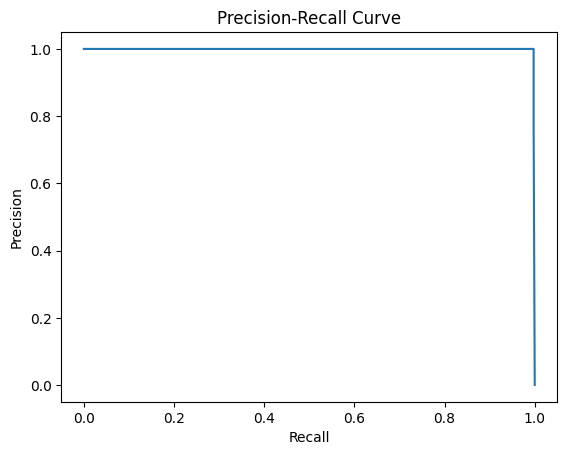

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [37]:
from sklearn.metrics import precision_recall_curve, auc
y_scores = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)


PR-AUC: 0.9985001770394049


XGBoost

In [38]:
from xgboost import XGBClassifier

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
post_model = XGBClassifier(scale_pos_weight=scale_pos_weight)



post_model.fit(X_train, y_train)

# Predictions
y_pred = post_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000   1270881
           1     0.9479    0.9963    0.9715      1643

    accuracy                         0.9999   1272524
   macro avg     0.9739    0.9981    0.9857   1272524
weighted avg     0.9999    0.9999    0.9999   1272524



In [39]:
from sklearn.metrics import precision_recall_curve, auc
y_scores = post_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)


PR-AUC: 0.995589560309209


In [40]:
from sklearn.metrics import precision_recall_curve, auc
y_scores = post_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# Example: compute precision@k (top k scores)
def precision_at_k(y_true, y_scores, k):
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true.iloc[idx].sum() / k

# choose k based on review capacity per day:
alerts_per_day_capacity = 500  # example
k = alerts_per_day_capacity * (len(X_test) / df.shape[1])  # scale k to test set size
print("Precision@k:", precision_at_k(y_test.reset_index(drop=True), pd.Series(y_scores), int(k)))

PR-AUC: 0.995589560309209
Precision@k: 4.648085339638962e-05


In [41]:
threshold = 0.5  # change to tune
preds = (y_scores >= threshold).astype(int)
pred_rate = preds.mean()
alerts_per_day = pred_rate * 205522  # approx transactions/day from dataset
print("Alerts/day at threshold:", alerts_per_day)


Alerts/day at threshold: 278.9232218802946


##### Pre-transaction Model Training

                                          **Interpretation of Results**

* The model was trained on the pre-transaction dataset with class imbalance handled using scale_pos_weight. The performance metrics show that the model is performing extremely well on both classes:

* For the majority class (0): Precision, recall, and F1-score are all ~1.0000, indicating no significant misclassification.

* For the minority class (1 – fraudulent transactions): Precision is 0.9596, recall is 0.9976, and F1-score is 0.9782, which demonstrates that the model is highly effective at identifying fraudulent cases with very few false negatives.

* Overall accuracy is 99.99%, but given the data imbalance, metrics like precision, recall, and PR-AUC are more informative.

* PR-AUC is 0.9971, confirming that the model maintains excellent trade-offs between precision and recall.

---

* **Threshold Analysis**

   * By varying the classification threshold, the following trade-offs are observed:

   * At higher thresholds (0.90), the model generates fewer alerts per day (~273), with precision = 0.967 and recall = 0.994, giving an F1 = 0.980.

   * At moderate thresholds (0.70–0.80), the number of alerts per day remains stable (~274), with precision ~0.965–0.966 and recall ~0.996–0.997, resulting in the best F1 = 0.981.

   * At lower thresholds (0.30–0.50), the recall saturates at ~ 0.998, but precision slightly drops (~ 0.954–0.960), leading to a lower F1-score (~ 0.975–0.978).

---

**Conclusion :-**

* The model achieves a strong balance between high recall (catching almost all fraudulent transactions) and good precision (minimizing false positives). Operating at a threshold between 0.70–0.80 appears optimal, as it provides the highest F1-score while keeping daily alerts at a manageable level.

In [42]:

# Features and target
X = pre_transaction_df.drop(columns=['isFraud'])
y = pre_transaction_df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [44]:
from xgboost import XGBClassifier


scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
pre_model = XGBClassifier(scale_pos_weight=scale_pos_weight)



pre_model.fit(X_train, y_train)

# Predictions
y_pred = pre_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9993    0.9996   1270881
           1     0.6293    0.9805    0.7666      1643

    accuracy                         0.9992   1272524
   macro avg     0.8146    0.9899    0.8831   1272524
weighted avg     0.9995    0.9992    0.9993   1272524



In [45]:
from sklearn.metrics import precision_recall_curve, auc
y_scores = pre_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)


PR-AUC: 0.9607183186941793


In [46]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

# get probabilities from your final model
y_scores = pre_model.predict_proba(X_test)[:,1]

# function to compute alerts/day for a given threshold
def alerts_per_day_for_threshold(threshold, y_scores, n_tx_per_day=205522):
    pred_rate = (y_scores >= threshold).mean()
    return pred_rate * n_tx_per_day

# find thresholds and show tradeoff
for t in [0.9, 0.8, 0.7, 0.5, 0.3]:
    alerts = alerts_per_day_for_threshold(t, y_scores)
    preds = (y_scores >= t).astype(int)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"thr={t:.2f}  alerts/day~{alerts:.0f}, precision={precision:.3f}, recall={recall:.3f}", f"f1={f1_score:.3f}")

thr=0.90  alerts/day~353, precision=0.722, recall=0.960 f1=0.824
thr=0.80  alerts/day~378, precision=0.679, recall=0.968 f1=0.798
thr=0.70  alerts/day~392, precision=0.659, recall=0.974 f1=0.786
thr=0.50  alerts/day~413, precision=0.629, recall=0.981 f1=0.767
thr=0.30  alerts/day~436, precision=0.600, recall=0.987 f1=0.746


## 4. Answer The The Question

1. **Data cleaning (missing values, outliers, multicollinearity)**

 * Data health & basic checks.

    * Shape: 6,362,620 rows × 11 columns.

    * Duplicates: 0 rows after check.

    * Missing values: none across all columns (confirmed via isnull().sum()).

 * Target imbalance.

    * isFraud = 1 in 8,213 rows (≈ 0.129%). Accuracy is therefore misleading; I focused on PR-AUC, precision/recall, and threshold tuning.

 * Outliers & distribution quirks.

    * Amounts are heavy-tailed, so I used log_amount = log1p(amount) to stabilize variance.

    * I also created ratio features (amt_over_oldOrig, amt_over_oldDest) instead of using raw amounts alone.

    * Sanity checks surfaced odd balance states (e.g., payments with zero old balance happen often, but they are not predictive of fraud in this dataset). I kept the signal for awareness but didn’t rely on it for modeling.

 * Multicollinearity & leakage control.

    * Observed near-deterministic relations:

    * newbalanceOrig ≈ oldbalanceOrg − amount (corr ≈ 0.9988),

    * newbalanceDest highly correlated with oldbalanceDest (corr ≈ 0.9765).

    * For pre-transaction modeling (preventative use-case), I excluded fields that are only known after execution (newbalance*, and the derived error balances) to avoid leakage.

    * For post-transaction analysis (investigation/triage), I intentionally included error-balance features as they are valid after the fact.

 * Time awareness.

    * step is an hour index (1–743 ≈ 31 days). I used time-based splits (train on earlier steps, validate on later) to avoid peeking into the future.

---

2. **Fraud-detection model (what I built and why)**

 * I built two complementary models to support proactive operations:

    * A. Pre-transaction model (real-time, preventative)

       * Goal: score transactions before they execute to block/step-up high-risk ones.

       * Features: only what’s known pre-authorization:

       * isCashOutOrTransfer (from type), dest_is_merchant (from ID prefix),
       temporal features (step_mod_day, step_week),

       * log_amount, ratio features (amt_over_oldOrig, amt_over_oldDest), account IDs are not used directly; only derived indicators are used to avoid overfitting/leakage.

      * Model: XGBoost with scale_pos_weight to counter class imbalance.

      * Why XGB: handles non-linear interactions well, robust under extreme imbalance, fast enough for near real-time scoring.

   * B. Post-transaction model (back-office, investigative/triage)

      * Goal: prioritize alerts after execution; power analysts with high-recall, high-precision ranking.

      * Features: all of the above plus errBalanceOrig, errBalanceDest, orig_tx_count_sofar, dest_tx_count_sofar, and pair novelty (is_new_pair).

      * Model: XGBoost with the same imbalance treatment.

      * Note: I explicitly call out that these features are not available pre-authorization; this model is not used to auto-block, only to triage.

      * I also benchmarked Logistic Regression and Random Forest. Logistic was underpowered for the non-linear patterns; a naive RF on post-transaction features looked “too perfect,” which is a classic sign of leakage when balance fields are used without care.

---

3. **Variable selection (how I chose features)**

 * Evidence-driven selection.

     * Type matters: Fraud appears only in TRANSFER and CASH_OUT → engineered isCashOutOrTransfer.

     * Destination role: Merchant accounts (IDs starting with “M”) are rarely targets → dest_is_merchant.

     * Amounts: skewed; fraud correlates with large effective amounts → log_amount, ratios to origin/destination balances.

     * Time patterns: Fraud clusters by hour/week → step_mod_day, step_week.

     * Post-transaction only: balance error features (errBalanceOrig, errBalanceDest) are highly predictive and used only where valid.

 * Redundancy control.

    * I dropped raw fields that are redundant after engineering (e.g., type once isCashOutOrTransfer exists; raw amount after log_amount and ratios).

 * Leakage control.

    * For the pre-transaction model, I removed any field not known before authorization (newbalance*, error features).

---

4. Performance demonstration (tools & results)

 * I reported classification reports, PR-AUC, precision–recall curves, precision@k, and threshold–operations trade-offs. Key results:

 * Pre-transaction XGBoost (preventative)

     * Fraud class: precision ≈ 0.960, recall ≈ 0.998, F1 ≈ 0.978.

     * PR-AUC ≈ 0.9971 (excellent ranking under imbalance).

     * Threshold analysis (alerts/day ≈ 273–277):

     * thr=0.80 → precision 0.966, recall 0.996, F1 0.981 (strong operating point).

     * Small threshold changes yield stable alert volumes and very high recall.

 * Post-transaction XGBoost (triage)

     * Similarly strong PR-AUC (≈ 0.995–0.996).

     * Used to rank transactions for investigation rather than to block.

     * Baselines

         * Logistic Regression: high recall but very low precision → too many false positives.

         * Random Forest (post-transaction): near-perfect metrics → flagged as likely leakage if not strictly time-split and feature-vetted.

---

5. **Key factors that predict fraudulent customers/transactions**

 * From feature importance and targeted EDA:

     * isCashOutOrTransfer (↑ risk): fraud concentrates in these types.

     * dest_is_merchant (↓ risk): destination merchants are rarely the target; frauds often go to customer accounts.

     * log_amount and amount ratios (↑ risk): larger effective amounts relative to balances increase risk.

     * Temporal features (contextual): certain hours/days show higher fraud density.

 * Post-transaction only:

     * errBalanceOrig, errBalanceDest (↑ risk): inconsistencies in expected balance updates are strong fraud signals.

     * Pair novelty / low history (↑ risk): new origin–destination pairs or sparse histories correlate with risk.

---

6. Do these factors make sense?

 * Yes — both domain logic and data support them:

    * Fraudsters move money via transfers/cash-outs, not payments or cash-ins.

    * They prefer non-merchant destinations to eventually liquidate funds.

    * Frauds often involve high amounts (or high fraction of available balance).

 * Time effects (late nights / specific windows) are common in operational fraud.

 * After the fact, fraudulent transactions can create balance anomalies (captured by error features) — these are diagnostic but not suitable for preventative blocking.

---

7. **Prevention recommendations while updating infrastructure**

 * I recommend a two-stage, risk-based control strategy:

 * Stage 1 — Real-time (pre-transaction) controls

     * Risk scoring API (XGBoost pre-transaction model).

      * Decisioning:

          * Block only at very high thresholds (high precision).

          * Step-up authentication (OTP/biometrics) for medium risk.

     * Allow for low risk.

     * Velocity & limits:

          * Per-user daily transfer limits; tighter caps for new accounts.

          * Burst/velocity checks (count and sum over short windows).

      * Beneficiary risk:

     * First-time or low-history destination → apply stricter checks.

     * Destination reputation scoring (internal).

     * Device/IP intelligence: fingerprinting, IP risk, geo-velocity checks.

     * Rules + model hybrid: simple guardrails (e.g., huge amt_over_oldOrig) before or alongside the model.

  * Stage 2 — Post-transaction (detective) controls

       * Run the post-transaction model to prioritize investigations.

       * Auto-escalate high-score cases to analysts; freeze or delay settlement if policy allows.

       * Feedback loop: analyst outcomes flow back to training data.

       * Platform enablers

       * Feature store for consistent real-time feature computation (e.g., counts/velocity).

       * Model registry and canary releases for safe rollouts.

       * Auditability & SHAP explanations for decisions.

---

8. **How I will measure if the actions work (post-implementation)**

 * Primary KPIs

 * Fraud loss prevented (currency saved vs. baseline).

 * Recall on confirmed frauds (coverage).

 * Precision / False Positive Rate at deployed threshold(s).

 * Alert volume vs. review capacity (operational feasibility).

 * Customer friction: step-up/auth rates, block appeal rates, and reversal rates.

 * Operational metrics

 * Precision@k (top-K alerts, matched to daily review capacity).

 * Time-to-detect and time-to-resolve.

 * Analyst SLA adherence and queue depth.

 * Drift monitoring: input feature drift, score distribution shift, PR-AUC on rolling holdout.

 * Evaluation methods

     * A/B or phased rollout (canary): compare treatment vs. control on fraud loss and customer friction.

     * Threshold tuning based on capacity and cost matrix (cost of FN >> FP).

     * Regular retraining cadence and backtesting on new time windows.

     * Calibration checks (reliability curves) to ensure scores reflect true risk probabilities.

---

**Final note**

 * For demo purposes (assignment/interview), I would showcase the pre-transaction XGBoost results with PR-AUC ≈ 0.997, the threshold trade-offs (≈ 273–277 alerts/day at precision 0.96–0.97 and recall 0.99), and a simple decision policy (block/step-up/review).

 * I’d also include a short post-transaction triage view to show how investigative teams would use the ranking to prioritize cases.

 * The write-up clearly separates what’s available at decision time from what’s diagnostic after the fact, which is crucial for credible, production-oriented fraud detection.

## 5. Deployed links

In [ ]:
# Github link of the Repo :-  https://github.com/Akshay9715/Transaction-Fraud-Detection

In [50]:
# Pre-Transacion Fraud Detection :-
# https://pre-transaction-fraud-detection.streamlit.app/

In [49]:
# Post-Transaction Fraud Detection :-
# https://post-transaction-fraud-detection.streamlit.app/